In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from graphviz import Digraph
%matplotlib inline

In [2]:
h = 0.00001

a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print(d1)
print(d2)
print((d2 - d1) / h)

4.0
4.00001
0.9999999999621422


In [367]:
class Value:
    
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    
    def __repr__(self):
        return f"Value(data={self.data})"
    
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        
        return out
    
    
    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward

        return out
    
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self,), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        
        return out
    
    
    def __neg__(self): # -self
        return self * -1

    
    def __radd__(self, other): # other + self
        return self + other

    
    def __sub__(self, other): # self - other
        return self + (-other)

    
    def __rsub__(self, other): # other - self
        return other + (-self)

    
    def __rmul__(self, other): # other * self
        return self * other

    
    def __truediv__(self, other): # self / other
        return self * other**-1

    
    def __rtruediv__(self, other): # other / self
        return other * self**-1

    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [9]:
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']

    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    nodes, edges = trace(root)    
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

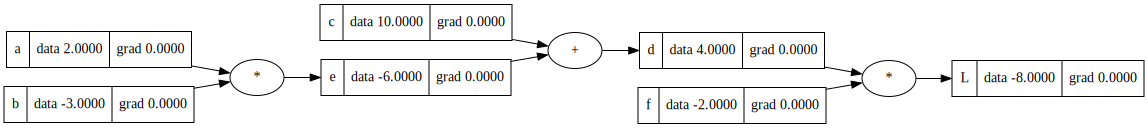

In [50]:
draw_dot(L)

In [24]:
a.grad = -3.0 * e.grad
b.grad = 2.0 * e.grad
c.grad = d.grad * 1.0
e.grad = d.grad * 1.0
f.grad = 4.0
d.grad = -2.0
L.grad = 1.0

In [281]:
# Perceptron
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.88137358, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

o = n.tanh(); o.label = 'o'

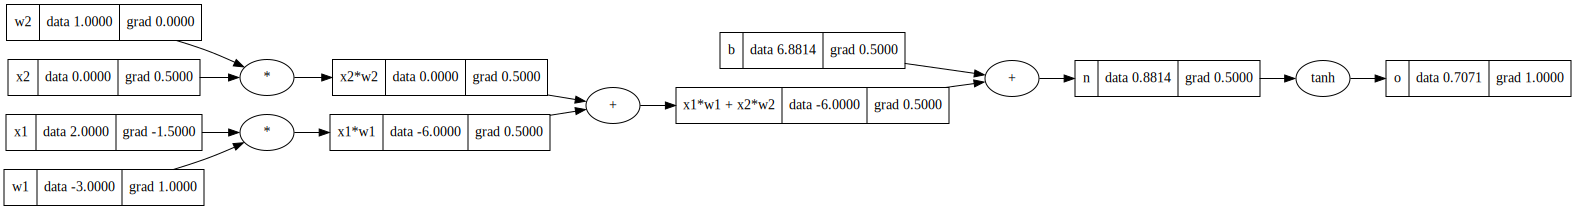

In [95]:
draw_dot(o)

In [368]:
# Perceptron
# inputs x1, x2
x1 = Value(2.0, label = 'x1')
x2 = Value(0.0, label = 'x2')
# weights w1, w2
w1 = Value(-3.0, label = 'w1')
w2 = Value(1.0, label = 'w2')
# bias
b = Value(6.88137358, label = 'b')

x1w1 = x1 * w1; x1w1.label = 'x1*w1'
x2w2 = x2 * w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e = (2 * n).exp(); e.label = 'e'
o = ((e - 1) / (e + 1)); o.label = 'o'

o.backward()

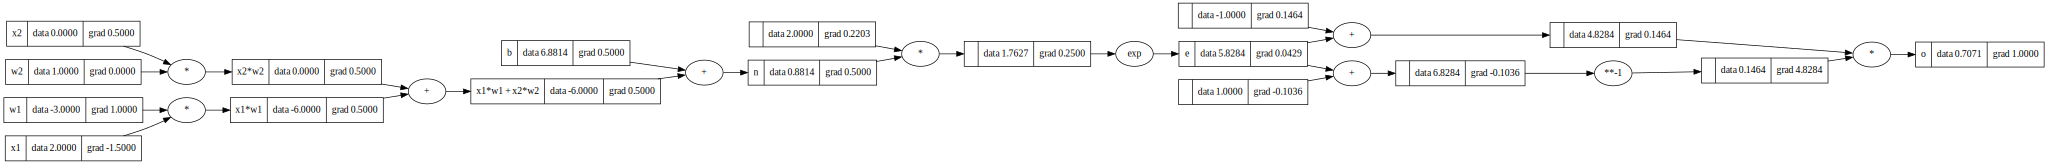

In [370]:
draw_dot(o)

In [449]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))
        
    def __call__(self, x):
        # sum(wi * xi) + b
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [535]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=0.692168920695247)

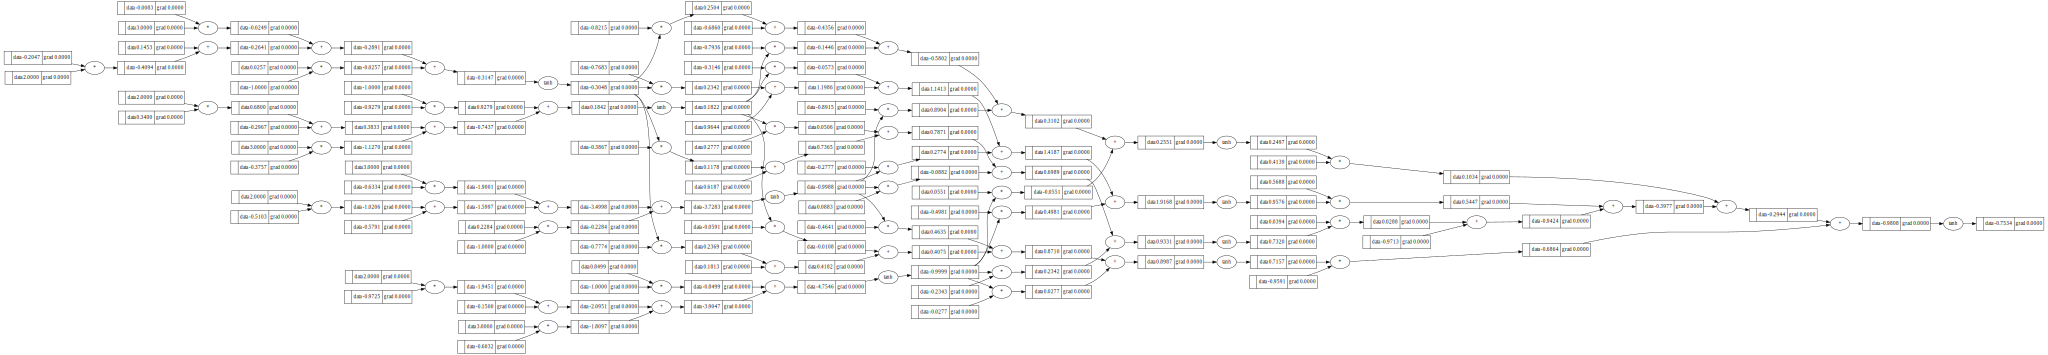

In [451]:
draw_dot(n(x))

In [532]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0]
]

ys = [1.0, -1.0, -1.0, 1.0]

In [542]:
for k in range(50):
    ypred = [n(x) for x in xs]
    loss = sum([(yout - ygt)**2 for ygt, yout in zip(ys, ypred)])
    
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    
    for p in n.parameters():
        p.data += -0.05 * p.grad
    
    print(k, loss.data)

0 0.027282823109420047
1 0.026272820476322362
2 0.025334658421401368
3 0.024460918542250742
4 0.02364517235390724
5 0.022881821149132914
6 0.022165966026342146
7 0.02149330164704587
8 0.020860028810410998
9 0.02026278206276771
10 0.01969856940546696
11 0.019164721802955344
12 0.018658850679216327
13 0.018178811964119256
14 0.017722675540137015
15 0.01728869916506492
16 0.016875306123067996
17 0.016481065995933124
18 0.016104678057292973
19 0.015744956881218315
20 0.015400819827805301
21 0.015071276125930774
22 0.014755417320074049
23 0.014452408886225229
24 0.01416148285314199
25 0.013881931290932317
26 0.01361310055020034
27 0.013354386152630123
28 0.013105228248580552
29 0.012865107569551053
30 0.012633541813687543
31 0.012410082411179958
32 0.012194311623734189
33 0.01198583993851338
34 0.011784303722225383
35 0.01158936310553221
36 0.011400700071805613
37 0.011218016727550035
38 0.011041033734646565
39 0.01086948888701487
40 0.010703135816396215
41 0.010541742813786482
42 0.0103850

In [543]:
ypred

[Value(data=0.9586342887544204),
 Value(data=-0.9579349818828418),
 Value(data=-0.9478840378637542),
 Value(data=0.943354078457611)]